# Scrap functions

#### Testing with queries

In [15]:
import pandas as pd

# read the excel file
excel_data = pd.read_excel('PIMS Sample Prompts.xlsx')

queries = []
for index, row in excel_data.iterrows():
    # Process each row
    queries.append(row['Prompt'])
    
queries = queries[:10]

## 1. Scraping content from the given engine

## Scraping content from html page

In [16]:
import requests
from bs4 import BeautifulSoup


def scrape_content_html(url):
    # Send a GET request to the URL
   
    
    response = requests.get(url)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract the desired information
        # Example: Extracting all paragraphs from the webpage
        paragraphs = soup.find_all('p')
        
        content = ""
        # Print or process the extracted information
#        for paragraph in paragraphs:
#            content += " " + paragraph.text

###### The below is to only return a shorter content. For the full content, use the commented commands above
        #for i in range(min(len(paragraphs), 3)):
### For the whole content:
        for i in range(len(paragraphs)):
            content += " " + paragraphs[i].text
        return content
    else:
        print("Failed to retrieve content. Status code:", response.status_code)
        return None

In [17]:
import requests
from bs4 import BeautifulSoup

########################################################
#### This function scrap the contents in the url
#### input: url
#### output: content (type: str)
####
#### required libraries:
# import requests
# from bs4 import BeautifulSoup
########################################################

def scrape_content_http(url):
    # Send a GET request to the URL
    headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        # Send a GET request to the URL with SSL verification disabled and custom headers
    response = requests.get(url, headers=headers, verify=False)
    #response = requests.get(url)
    
    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Parse the HTML content of the webpage
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extract the desired information
        # Example: Extracting all paragraphs from the webpage
        paragraphs = soup.find_all('p')
        
        content = ""
        # Print or process the extracted information
#        for paragraph in paragraphs:
#            content += " " + paragraph.text

###### The below is to only return a shorter content. For the full content, use the commented commands above
        #for i in range(min(len(paragraphs), 3)):
### For the whole content:
        for i in range(len(paragraphs)):
            content += " " + paragraphs[i].text
        return content
    else:
        print("Failed to retrieve content. Status code:", response.status_code)
        return None

###  2-1. Google News (working)

In [18]:
########################################################
#### This function scrap the titles, links, and dates of the first 20 articles from google news with the given query
#### input: query
#### output: the list of the title and link
####
#### required libraries:
# import requests
# from bs4 import BeautifulSoup
########################################################

def scrape_google_news(query):
    # Construct the Google News URL with the query
    url = f"https://news.google.com/search?q={query}"
   
    # Send a GET request to the URL
    response = requests.get(url)

    # Parse the HTML content of the page
    soup = BeautifulSoup(response.text, 'html.parser')

    # Find all the search result elements
    search_results = soup.find_all('div', class_='IL9Cne')
    date_elements = soup.find_all('time', class_='hvbAAd')


    # Extract the title and link of each search result
    scrap = []
    for i in range(min(len(search_results), 10)):
        title = search_results[i].find('a', class_ = 'JtKRv').text
        link = search_results[i].find('a')['href']
        link = 'https://news.google.com' + link[1:]
        date = date_elements[i]['datetime'][:10]    
        scrap.append({'title': title, 'link': link, 'date': date})   
    return scrap

### 2-3. Bing News (working)

In [19]:
def scrape_bing_news(query):
    url = f"https://www.bing.com/news/search?q={query}"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        scrap_results = []
        
        # Find all news results
        date_elements = soup.find_all('span', tabindex="0")
        search_results = soup.find_all('div', class_='t_s')
        
        # Iterate over the first five results
        for i in range(min(len(search_results), 10)):
            title = search_results[i].find('a', class_ = 'title').text
            link = search_results[i].find('a', class_ = 'title')['href']
            date = date_elements[i]['aria-label']
            scrap_results.append({ 'title': title, 'link': link,'date': date})
        
        return scrap_results
    else:
        print(f"Failed to fetch Bing search results for query: {query}")
        return None


### 2-4. Create the dataset for all engines

In [20]:
import time
import warnings
import urllib3

# Suppress only the specific warning
warnings.filterwarnings('ignore', category=urllib3.exceptions.InsecureRequestWarning)

search_engines = {
    'Google': (scrape_google_news,scrape_content_html),
    #'Yahoo': scrape_yahoo_news,
    'Bing': (scrape_bing_news,scrape_content_http)
    #'Maritime executive' : scrape_maritime_executive
    
}

data = []
for query in queries:
    for engine_name, (scrape_news_function, scrape_content) in search_engines.items():
        #print(f"Scraping {engine_name} for query: {query}")
        results = scrape_news_function(query)
        
        if results:
            for result in results[:len(results)]:  # Limiting to the top 20 results per engine
                data.append({
                    'Query': query,
                    'Engine': engine_name,
                    'Title': result['title'],
                    #'Link': result['link'],
                    'Content': scrape_content(result['link']),
                    'Date': result['date']
                })
                #print(data[len(data)-1])

        else:
            data.append({
                'Query': query,
                'Engine': engine_name,
                'Title': 'No Title',
                'Title': 'No content'
            })
            #print(data[len(data)-1])

        
        time.sleep(1)  # Adding a delay to be respectful of website policies

#### Data frame:
df = pd.DataFrame(data)

# Sauvegarder en CSV
df.to_csv('data_collected_google_bing.csv', index=False)


Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 401
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 403
Failed to retrieve content. Status code: 429


In [109]:
df.head(20)

,Query,Engine,Title,Content,Date
0,Vessel caught misreporting catch amount,Google,Sea Shepherd Global,"Wednesday, 05 Jun, 2024 Sea Shepherd Global s...",2024-06-05
1,Vessel caught misreporting catch amount,Google,New rules tighten controls on EU…,"Today, the Environmental Justice Foundation c...",2024-05-24
2,Vessel caught misreporting catch amount,Google,"N.S. boat captain, 2 companies fined $125K for...","A boat captain from Sambro, N.S., with a hist...",2023-09-13
3,Vessel caught misreporting catch amount,Google,Move the IUU Fight Up the Food Chain | Proceed...,None,2023-10-31
4,Vessel caught misreporting catch amount,Google,Surprise! Media is misreporting the source of ...,"Early this morning, the Fremantle Highway, a ...",2023-07-26
5,Vessel caught misreporting catch amount,Google,Sea Shepherd Global,"Monday, 25 Mar, 2024 In a decisive strike aga...",2024-03-25
6,Vessel caught misreporting catch amount,Google,Northwest NDP MP slams Liberal government over...,Sign In Subscribe Now Skeena-Bulkley Valley...,2022-11-23
7,Vessel caught misreporting catch amount,Google,Fish and Overfishing,How are fish stocks changing across the world...,2021-10-11
8,Vessel caught misreporting catch amount,Google,Three Fishing Companies and Five Vessel Master...,None,2023-06-23
9,Vessel caught misreporting catch amount,Google,Catch Me If You Can: The Global Pursuit of a F...,This article is also available in audio forma...,2020-03-03


## TF-IDF

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd


keywords = [
    # About documents
    ['unreport', 'unreported', 'unreporting', 'unreports'],
    ['underreport', 'underreports', 'underreported', 'underreporting'],
    ['undocumented', 'undocument', 'undocumenting', 'undocuments'],
    ['misrepresent', 'misrepresented', 'misrepresenting', 'misreports'],
    ['register', 'registers', 'registered', 'registering', 'unregister', 'unregisters', 'unregistered', 'unregistering'],
    ['logbook', 'logged'],
    ['declaration', 'declare', 'declares', 'declared', 'declaring', 'underdeclaration', 'under-declaration'],
    ['label', 'mislabel', 'labeling', 'labeled', 'labels', 'mislabeling', 'mislabled', 'mislables'],
    # About being false
    ['false', 'falsify', 'falsifies', 'falsifying', 'falsifies', 'falsified', 'falsification', 'fake', 'manipulated', 'manipulate', 'manipulates'],
    ['fraud', 'fraudulence', 'hoax'],
    # About amounts
    ['volume', 'quota', 'exceed', 'exceeds', 'exceeded', 'exceeding', 'inflation'],
    # Fish, Ocean, port 
    ['catch', 'bycatch', 'harvest', 'juvenile', 'invasive'],
    ['farmed', 'farming'], 
    ['ocean', 'sea', 'seas'],
    ['port'],
    ['transshipment'],
    ['landing'],
    ['selective'],    
#    ['commercial', 'industrial'],
    # Crime
    ['offend', 'offended', 'offends', 'violate', 'violates', 'violated', 'violation'],
    ['regulation', 'regulate', 'regulated', 'regulates', 'regulating', 'regulations', 'regulates'],
    ['alter', 'altering', 'alters'],
    ['exploit', 'exploited', 'exploiting', 'exploits'],
    ['impose', 'imposed', 'imposes', 'imposing'],
    ['inspector', 'inspectors', 'inspect', 'inspects', 'inspected', 'inspecting','investigate', 'investigates', 'investigated','investigating','investigator'],
]
# Fill None values with an empty string
df = df.fillna('no content')

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Combine all text data (queries, titles, and content) for consistent vectorization
#all_texts = df['Query'].tolist() + df['Title'].tolist() \
#+ df['Content'].tolist()+ keywords
all_texts = df['Query'].tolist() + df['Title'].tolist() \
+ df['Content'].tolist()+ keywords

# Fit the vectorizer on all texts
vectorizer.fit(all_texts)

# Transform queries, titles, and content separately
query_vectors = vectorizer.transform(df['Query'].tolist())
title_vectors = vectorizer.transform(df['Title'].tolist())
content_vectors = vectorizer.transform(df['Content'].tolist())
#keywords_vectors = vectorizer.transform(keywords)


# Calculate cosine similarity
relevance_scores_title = []
relevance_scores_content = []
relevance_scores_keywords = []

for i in range(len(df)):
    query_vector = query_vectors[i]
    title_vector = title_vectors[i]
    content_vector = content_vectors[i]
    keywords_vector = keywords_vectors[i]

    rs_title = cosine_similarity(query_vector, title_vector)[0][0]
    rs_content = cosine_similarity(query_vector, content_vector)[0][0]
    #rs_content = cosine_similarity(keywords_vector, content_vector)[0][0]

    relevance_scores_title.append(rs_title)
    relevance_scores_content.append(rs_content)
    #relevance_scores_keywords.append(rs_content)

# Add relevance scores to the DataFrame
df['rs_title'] = relevance_scores_title
df['rs_content'] = relevance_scores_content
#df['rs_keywords'] = relevance_scores_keywords


df.head(20)

,Query,Engine,Title,Content,Date,rs_title,rs_content
0,Vessel caught misreporting catch amount,Google,Sea Shepherd Global,"Wednesday, 05 Jun, 2024 Sea Shepherd Global s...",2024-06-05,0.000000,0.008868
1,Vessel caught misreporting catch amount,Google,New rules tighten controls on EU…,"Today, the Environmental Justice Foundation c...",2024-05-24,0.000000,0.019457
2,Vessel caught misreporting catch amount,Google,"N.S. boat captain, 2 companies fined $125K for...","A boat captain from Sambro, N.S., with a hist...",2023-09-13,0.000000,0.020099
3,Vessel caught misreporting catch amount,Google,Move the IUU Fight Up the Food Chain | Proceed...,no content,2023-10-31,0.000000,0.000000
4,Vessel caught misreporting catch amount,Google,Surprise! Media is misreporting the source of ...,"Early this morning, the Fremantle Highway, a ...",2023-07-26,0.123775,0.013857
5,Vessel caught misreporting catch amount,Google,Sea Shepherd Global,"Monday, 25 Mar, 2024 In a decisive strike aga...",2024-03-25,0.000000,0.020911
6,Vessel caught misreporting catch amount,Google,Northwest NDP MP slams Liberal government over...,Sign In Subscribe Now Skeena-Bulkley Valley...,2022-11-23,0.000000,0.042632
7,Vessel caught misreporting catch amount,Google,Fish and Overfishing,How are fish stocks changing across the world...,2021-10-11,0.000000,0.045330
8,Vessel caught misreporting catch amount,Google,Three Fishing Companies and Five Vessel Master...,no content,2023-06-23,0.185372,0.000000
9,Vessel caught misreporting catch amount,Google,Catch Me If You Can: The Global Pursuit of a F...,This article is also available in audio forma...,2020-03-03,0.091472,0.028528


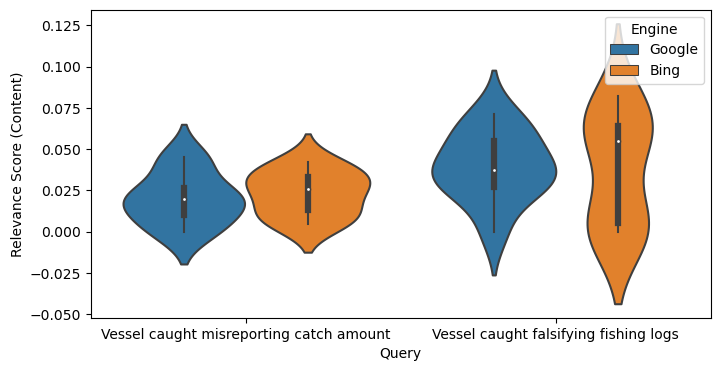

In [115]:

plt.figure(figsize=(8, 4))
#sns.violinplot(x='Query', y='rs_content', hue='Engine', data=df, split=True, inner='quartile')
sns.violinplot(data=df, x="Query", y="rs_content", hue="Engine", fill=False)
plt.xlabel('Query')
plt.ylabel('Relevance Score (Content)')
plt.show()

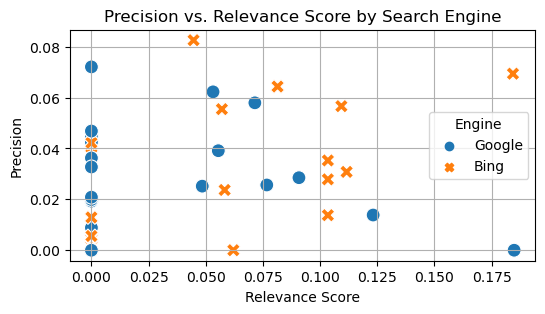

In [88]:

# Plotting using seaborn
plt.figure(figsize=(6, 3))
sns.scatterplot(data=df, x='rs_title',y='rs_content',  hue='Engine', style='Engine', s=100)
plt.title('Precision vs. Relevance Score by Search Engine')
plt.xlabel('Relevance Score')
plt.ylabel('Precision')
#plt.xlim(-0.1, 1.1)
#plt.ylim(-0.1, 1.1)
plt.legend(title='Engine', loc='best')
plt.grid(True)
plt.show()

<Figure size 1000x800 with 0 Axes>

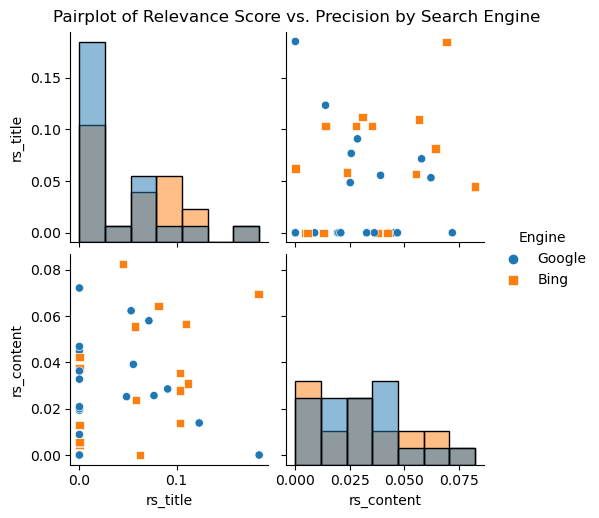

In [87]:
# Create a pairplot using seaborn

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.pairplot(df, hue='Engine', vars=['rs_title', 'rs_content'], diag_kind='hist', markers=['o', 's'])
plt.suptitle('Pairplot of Relevance Score vs. Precision by Search Engine', y=1.02)
plt.show()

In [112]:
df.head()

,Query,Engine,Title,Content,Date,rs_title,rs_content
0,Vessel caught misreporting catch amount,Google,Sea Shepherd Global,"Wednesday, 05 Jun, 2024 Sea Shepherd Global s...",2024-06-05,0.000000,0.008868
1,Vessel caught misreporting catch amount,Google,New rules tighten controls on EU…,"Today, the Environmental Justice Foundation c...",2024-05-24,0.000000,0.019457
2,Vessel caught misreporting catch amount,Google,"N.S. boat captain, 2 companies fined $125K for...","A boat captain from Sambro, N.S., with a hist...",2023-09-13,0.000000,0.020099
3,Vessel caught misreporting catch amount,Google,Move the IUU Fight Up the Food Chain | Proceed...,no content,2023-10-31,0.000000,0.000000
4,Vessel caught misreporting catch amount,Google,Surprise! Media is misreporting the source of ...,"Early this morning, the Fremantle Highway, a ...",2023-07-26,0.123775,0.013857


### Relevant paper

In [91]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
from requests.exceptions import RequestException
import warnings
import urllib3

# Suppress only the specific warning
warnings.filterwarnings('ignore', category=urllib3.exceptions.InsecureRequestWarning)



# Function to check if URL is accessible
def is_accessible(url):
    try:
        response = requests.get(url)
        return response.status_code == 200  # Return True if response is OK (status code 200)
    except requests.exceptions.RequestException:
        return False


# Read the excel files
relevant_paper = pd.read_excel('Spyglass-Extract-DB-NCIS.xlsx')
excel_data = pd.read_excel('PIMS Sample Prompts.xlsx')

# Extract the 'Source' column from relevant_paper
links = relevant_paper['Source'].tolist()

# Remove the first element from the links list if it's 'Link of reference'
if links and links[0] == 'Link of reference':
    links = links[1:]

# Limit links to the first 10
links = links[2:30]

# Filter out URLs that are not accessible
accessible_urls = [url for url in links if is_accessible(url)]

# Extract the 'Prompt' column from excel_data
queries = excel_data['Prompt'].tolist()

# Limit queries to the first 2
queries = queries[:2]

# Create a list to hold all rows
data = {'Query': [],  'Content': []}

# Populate the data dictionary with each query and each link
for query in queries:
    for link in accessible_urls:
        data['Query'].append(query)
       # data['Link'].append(link)
        
        # Scrape content for the current link
        content = scrape_content_html(link)
        data['Content'].append(content)

# Create the DataFrame
df_paper = pd.DataFrame(data)

# Print the DataFrame to verify
print(df_paper)


                                      Query  \
0   Vessel caught misreporting catch amount   
1   Vessel caught misreporting catch amount   
2   Vessel caught misreporting catch amount   
3   Vessel caught misreporting catch amount   
4   Vessel caught misreporting catch amount   
5   Vessel caught misreporting catch amount   
6   Vessel caught misreporting catch amount   
7   Vessel caught misreporting catch amount   
8   Vessel caught misreporting catch amount   
9   Vessel caught misreporting catch amount   
10  Vessel caught misreporting catch amount   
11  Vessel caught misreporting catch amount   
12    Vessel caught falsifying fishing logs   
13    Vessel caught falsifying fishing logs   
14    Vessel caught falsifying fishing logs   
15    Vessel caught falsifying fishing logs   
16    Vessel caught falsifying fishing logs   
17    Vessel caught falsifying fishing logs   
18    Vessel caught falsifying fishing logs   
19    Vessel caught falsifying fishing logs   
20    Vessel 

In [92]:
df_paper.head()

,Query,Content
0,Vessel caught misreporting catch amount,São Toméan Authorities Pursue Legal Action in...
1,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...
2,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...
3,Vessel caught misreporting catch amount,"This site provides the best available, up-to-..."
4,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...


In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# Fill None values with an empty string
df_paper = df_paper.fillna('no content')

# Initialize the vectorizer
vectorizer = TfidfVectorizer()

# Combine all text data (queries, titles, and content) for consistent vectorization
all_texts = df_paper['Query'].tolist()  + df_paper['Content'].tolist()

# Fit the vectorizer on all texts
vectorizer.fit(all_texts)

# Transform queries, titles, and content separately
query_vectors = vectorizer.transform(df_paper['Query'].tolist())
#title_vectors = vectorizer.transform(df['Title'].tolist())
content_vectors = vectorizer.transform(df_paper['Content'].tolist())

# Calculate cosine similarity
relevance_scores_title = []
relevance_scores_content = []

for i in range(len(df_paper)):
    query_vector = query_vectors[i]
    #title_vector = title_vectors[i]
    content_vector = content_vectors[i]
    rs_content = cosine_similarity(query_vector, content_vector)[0][0]


    relevance_scores_content.append(rs_content)

# Add relevance scores to the DataFrame
df_paper['rs_content'] = relevance_scores_content




In [94]:
df_paper.head(20)

,Query,Content,rs_content
0,Vessel caught misreporting catch amount,São Toméan Authorities Pursue Legal Action in...,0.011326
1,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...,0.004599
2,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...,0.004599
3,Vessel caught misreporting catch amount,"This site provides the best available, up-to-...",0.050446
4,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...,0.004599
5,Vessel caught misreporting catch amount,Internet Explorer lacks support for the featu...,0.004599
6,Vessel caught misreporting catch amount,"Share this article View from Raoul Island, on...",0.037137
7,Vessel caught misreporting catch amount,"Share this article View from Raoul Island, on...",0.037137
8,Vessel caught misreporting catch amount,Peruvian authorities have detained the world'...,0.006052
9,Vessel caught misreporting catch amount,Mothership formerly known as Lafayette is on ...,0.005929


In [95]:
# Assuming df is your DataFrame containing the data
# You can access the 'Content' column of the DataFrame where 'Title' is not 'Error: Status code 404'

relevant_content = df_paper.loc[df['Title'] != 'Error: Status code 404', 'Content']

# Print or use relevant_content as needed
print(relevant_content)


0      São Toméan Authorities Pursue Legal Action in...
1      Internet Explorer lacks support for the featu...
2      Internet Explorer lacks support for the featu...
3      This site provides the best available, up-to-...
4      Internet Explorer lacks support for the featu...
5      Internet Explorer lacks support for the featu...
6      Share this article View from Raoul Island, on...
7      Share this article View from Raoul Island, on...
8      Peruvian authorities have detained the world'...
9      Mothership formerly known as Lafayette is on ...
10     Internet Explorer lacks support for the featu...
11     Internet Explorer lacks support for the featu...
12     São Toméan Authorities Pursue Legal Action in...
13     Internet Explorer lacks support for the featu...
14     Internet Explorer lacks support for the featu...
15     This site provides the best available, up-to-...
16     Internet Explorer lacks support for the featu...
17     Internet Explorer lacks support for the f

In [96]:
import requests
from bs4 import BeautifulSoup

# List of URLs
urls = [
    "http://www.abc.net.au/news/2016-12-30/tasmanian-fishing-identities-held-after-record-cocaine-bust/8154188",
    "http://www.maritime-executive.com/article/spanish-long-liner-detained-over-shark-fishing",
    "http://www.greenpeace.org/seasia/PageFiles/745330/Turn-The-Tide.pdf",
    "http://news.cision.com/sea-shepherd-global/r/massive-spanish-shark-finning-operation-uncovered-in-sao-tome-and-principe,c2369004",
    "https://cdn2.hubspot.net/hubfs/183611/Landing_Page_Documents/IUU_Activities_in_Somalia-_eE_use_case.pdf",
    "http://www.nmfs.noaa.gov/ia/iuu/msra_page/2013_biennial_report_to_congress__jan_11__2013__final.pdf",
    "https://nltimes.nl/2015/05/22/marines-discover-6000-kilo-marijuana-shipment",
    "https://stopillegalfishing.com/news-articles/22-thai-crewmembers-await-repatriation-thai-owned-somali-seven-fishing-vessels/",
    "http://iuu-vessels.org/iuu/iuu/search"
]

# Function to fetch and parse content
def fetch_content(url):
    try:
        # Fetch the webpage content
        response = requests.get(url)
        response.raise_for_status()  # Raise error for bad status codes

        # Parse content with BeautifulSoup
        soup = BeautifulSoup(response.text, 'html.parser')

        # Extract main content (adjust according to the structure of each site)
        main_content = soup.find('div', class_='content')  # Example: find content div

        if main_content:
            return main_content.get_text(separator='\n')  # Get text with new lines
        else:
            return "No main content found."

    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")
        return None

# Iterate through URLs and fetch content
for url in urls:
    print(f"Fetching content from: {url}")
    content = fetch_content(url)
    if content:
        print(content)
    print("--------------------------------------")


Fetching content from: http://www.abc.net.au/news/2016-12-30/tasmanian-fishing-identities-held-after-record-cocaine-bust/8154188
No main content found.
--------------------------------------
Fetching content from: http://www.maritime-executive.com/article/spanish-long-liner-detained-over-shark-fishing
Error fetching http://www.maritime-executive.com/article/spanish-long-liner-detained-over-shark-fishing: 404 Client Error: Not Found for url: https://www.maritime-executive.com/403.shtml
--------------------------------------
Fetching content from: http://www.greenpeace.org/seasia/PageFiles/745330/Turn-The-Tide.pdf
Error fetching http://www.greenpeace.org/seasia/PageFiles/745330/Turn-The-Tide.pdf: 404 Client Error: Not Found for url: https://www.greenpeace.org/seasia/PageFiles/745330/Turn-The-Tide.pdf
--------------------------------------
Fetching content from: http://news.cision.com/sea-shepherd-global/r/massive-spanish-shark-finning-operation-uncovered-in-sao-tome-and-principe,c2369004

In [97]:
import pandas as pd
import requests
import PyPDF2  # Library for working with PDFs
from io import BytesIO
from requests.exceptions import RequestException

# Function to scrape content from a URL
def scrape_content(url):
    try:
        # Send a GET request to the URL
        response = requests.get(url)
        
        # Check if the request was successful (status code 200)
        if response.status_code == 200:
            # Check if the response content type is PDF
            if 'application/pdf' in response.headers.get('content-type', ''):
                # Parse PDF content
                pdf_content = BytesIO(response.content)
                pdf_reader = PyPDF2.PdfFileReader(pdf_content)
                
                # Extract text from all pages
                content = ""
                for page_num in range(pdf_reader.numPages):
                    page = pdf_reader.getPage(page_num)
                    content += page.extract_text()
                
                return content.strip()  # Strip to remove leading/trailing whitespace
            
            else:
                # Assume it's HTML content (similar to previous example)
                soup = BeautifulSoup(response.text, 'html.parser')
                paragraphs = soup.find_all('p')
                content = ""
                for i in range(min(len(paragraphs), 3)):
                    content += " " + paragraphs[i].text.strip()
                
                return content.strip()  # Strip again to ensure no leading/trailing whitespace
        
        else:
            return f"Error: Status code {response.status_code}"
    
    except RequestException as e:
        return f"Error: {str(e)}"
    except PyPDF2.utils.PdfReadError as e:
        return f"Error reading PDF: {str(e)}"

# Read the excel files
relevant_paper = pd.read_excel('Spyglass-Extract-DB-NCIS.xlsx')
excel_data = pd.read_excel('PIMS Sample Prompts.xlsx')

# Extract the 'Source' column from relevant_paper
links = relevant_paper['Source'].tolist()

# Remove the first element from the links list if it's 'Link of reference'
if links and links[0] == 'Link of reference':
    links = links[1:]

# Limit links to the first 10
links = links[150:160]

# Extract the 'Prompt' column from excel_data
queries = excel_data['Prompt'].tolist()

# Limit queries to the first 2
queries = queries[:2]

# Create a list to hold all rows
data = {'Query': [], 'Link': [], 'Content': []}

# Populate the data dictionary with each query and each link
for query in queries:
    for link in links:
        data['Query'].append(query)
        data['Link'].append(link)
        
        # Scrape content for the current link
        content = scrape_content(link)
        data['Content'].append(content)

# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame to verify



In [98]:
df['Link']

0     https://www.hindustantimes.com/mumbai-news/in-...
1     https://www.hindustantimes.com/mumbai-news/in-...
2     https://www.seafoodsource.com/news/environment...
3     https://news.mongabay.com/2020/05/chinese-boat...
4     https://news.mongabay.com/2020/05/chinese-boat...
5     https://news.mongabay.com/2020/05/chinese-boat...
6     https://news.mongabay.com/2020/05/chinese-boat...
7     https://news.mongabay.com/2020/10/breaking-dea...
8     https://news.mongabay.com/2020/10/breaking-dea...
9     https://www.hindustantimes.com/mumbai-news/in-...
10    https://www.hindustantimes.com/mumbai-news/in-...
11    https://www.seafoodsource.com/news/environment...
12    https://news.mongabay.com/2020/05/chinese-boat...
13    https://news.mongabay.com/2020/05/chinese-boat...
14    https://news.mongabay.com/2020/05/chinese-boat...
15    https://news.mongabay.com/2020/05/chinese-boat...
16    https://news.mongabay.com/2020/10/breaking-dea...
17    https://news.mongabay.com/2020/10/breaking

In [99]:
df.head(20)

,Query,Link,Content
0,Vessel caught misreporting catch amount,https://www.hindustantimes.com/mumbai-news/in-...,Error: Status code 401
1,Vessel caught misreporting catch amount,https://www.hindustantimes.com/mumbai-news/in-...,Error: Status code 401
2,Vessel caught misreporting catch amount,https://www.seafoodsource.com/news/environment...,Search Share A trawler owned by a Chinese dist...
3,Vessel caught misreporting catch amount,https://news.mongabay.com/2020/05/chinese-boat...,Error: Status code 403
4,Vessel caught misreporting catch amount,https://news.mongabay.com/2020/05/chinese-boat...,Error: Status code 403
5,Vessel caught misreporting catch amount,https://news.mongabay.com/2020/05/chinese-boat...,Error: Status code 403
6,Vessel caught misreporting catch amount,https://news.mongabay.com/2020/05/chinese-boat...,Error: Status code 403
7,Vessel caught misreporting catch amount,https://news.mongabay.com/2020/10/breaking-dea...,Error: Status code 403
8,Vessel caught misreporting catch amount,https://news.mongabay.com/2020/10/breaking-dea...,Error: Status code 403
9,Vessel caught falsifying fishing logs,https://www.hindustantimes.com/mumbai-news/in-...,Error: Status code 401


In [100]:
import requests

def scrape_pdf_from_url(url):
    """
    Function to scrape a PDF file from a given URL and return its content.

    Parameters:
    - url (str): The URL pointing to the PDF file.

    Returns:
    - bytes or None: The content of the PDF file as bytes if scraped successfully, None otherwise.
    """
    try:
        headers = {'User-Agent': 'Mozilla/5.0'}  # Example User-Agent header
        response = requests.get(url, headers=headers)
        
        if response.status_code == 200:
            return response.content
        else:
            print(f"Failed to scrape PDF from {url}. Status code: {response.status_code}")
            return None
    
    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None


In [101]:
scrape_content("https://www.fisheries.noaa.gov/topic/international-affairs")

'Internet Explorer lacks support for the features of this website. For the best experience, please use a modern browser such as Chrome, Firefox, or Edge. U.S. fisheries are a global model of success. We are leading the way in science-based management and in the use of innovative strategies to achieve and maintain sustainable fisheries and to preserve and rebuild protected species, including marine mammals and sea turtles. As one of the largest seafood-consuming and fishing nations, it is critical that we take an active role in shaping the conservation and management regimes of international fisheries. We work to meet the demand of U.S. consumers that imported seafood be safe, legal, and sustainable and ensure confidence in U.S. seafood by protecting and strengthening the seafood market through international engagement.'

In [102]:
url = "https://www.fisheries.noaa.gov/topic/international-affairs"

pdf_content = scrape_pdf_from_url(url)

if pdf_content:
    # Process or use the pdf_content as needed
    print(f"PDF content length: {len(pdf_content)} bytes")
else:
    print("Failed to fetch PDF content.")


PDF content length: 241311 bytes


In [103]:
pdf_content

b'\n\n<!DOCTYPE html>\n<html lang="en" dir="ltr" prefix="content: http://purl.org/rss/1.0/modules/content/  dc: http://purl.org/dc/terms/  foaf: http://xmlns.com/foaf/0.1/  og: http://ogp.me/ns#  rdfs: http://www.w3.org/2000/01/rdf-schema#  schema: http://schema.org/  sioc: http://rdfs.org/sioc/ns#  sioct: http://rdfs.org/sioc/types#  skos: http://www.w3.org/2004/02/skos/core#  xsd: http://www.w3.org/2001/XMLSchema# ">\n  <head>\n    <meta charset="utf-8" /><script type="text/javascript">(window.NREUM||(NREUM={})).init={ajax:{deny_list:["bam.nr-data.net"]}};(window.NREUM||(NREUM={})).loader_config={licenseKey:"249ea9cb86",applicationID:"659846010"};;/*! For license information please see nr-loader-rum-1.260.1.min.js.LICENSE.txt */\n(()=>{var e,t,r={234:(e,t,r)=>{"use strict";r.d(t,{P_:()=>v,Mt:()=>b,C5:()=>s,OP:()=>k,lF:()=>P,Yu:()=>_,Dg:()=>m,CX:()=>c,GE:()=>w,sU:()=>N});var n=r(8632),i=r(9567);const o={beacon:n.ce.beacon,errorBeacon:n.ce.errorBeacon,licenseKey:void 0,applicationID:vo